# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Fri Mar 24 23:21:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   49C    P0    96W / 300W |      0MiB /  5067MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 

In [22]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [24]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [25]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [26]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

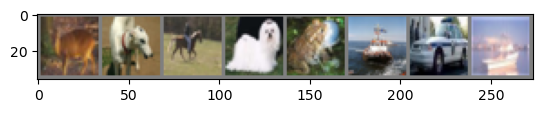

deer  dog   horse dog   frog  ship  car   ship 


In [27]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [28]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [95]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL):
        
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout2d(p=0.1),
        )

In [96]:
class Backbone(nn.Module):

  def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
    super(Backbone, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug

    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    
    self.linear = nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
        #nn.Tanh(),
        # nn.LeakyReLU(),
        # nn.Linear(in_features=k, out_features=k, bias=True),  
        #nn.ReLU(),
        nn.Sigmoid(),      # Non Linear Activation
    )

    self.conv_blocks = nn.ModuleList([
        ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        for _ in range(k)
    ])
    
    self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

  def forward(self, x):
    sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"{sap_out.shape=}")

    g_out = self.linear(sap_out)
    if self.debug: print(f"{g_out.shape=}")
    if self.debug: print(f"{g_out=}")

    outs = list()
    for a, conv_block in zip(g_out.transpose(0, 1), self.conv_blocks):
    #for conv2d in self.conv2ds:
      c_out = conv_block(x)
      if self.debug: print(f"{c_out.shape=}")
      if self.debug: print(f"{a.shape=}, \n{a=}")

      out = a.reshape(x.shape[0], 1, 1, 1)*c_out
      if self.debug: print(f"{out.shape=}")
      outs.append(out)
      #outs.append(c_out)
      
    out = sum(outs)
    if self.debug: print(f"{out.shape=}")
    
    out = self.batch_norm(out)
    if self.debug: print(f"{batch_out.shape=}")

    return out

In [97]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            #nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=False),
            # nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=False),
            # nn.Dropout(p=0.2),
            #nn.ReLU(),
            #nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=False),
            nn.Linear(in_features=in_features, out_features=out_features, bias=False),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

In [98]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.ModuleList([
            Backbone(
                in_channels=self.channels[i], 
                out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1], out_features=len(CLASSES), debug=debug)

    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        
        for backbone in self.backbones:
            x = backbone(x)
    
        out = self.classifier(x)

        return out

In [99]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, trainloader, testloader, logs_per_epoch=4) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader

        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, epochs=3, use_gpu=False):
        
        correct = 0
        total = 0
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            print(f"Train Loss : {self.losses[-1]}")
            
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            self.eval()

        self.epochs += epochs
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 3)

        X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        plt.tight_layout()
        fig.show()
    

In [100]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [101]:
def model_summary(model, trainloader):

    img_sizes = list()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            if USE_GPU:
                images = images.to('cuda')
                labels = labels.to('cuda')
            
            x = images
            
            img_sizes.append(x.shape[-1])
            for backbone in model.backbones:
                x = backbone(x)
                img_sizes.append(x.shape[-1])
            break
                
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")


## Experiment

In [135]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 128, 256, 512, 1028] #19, ]
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')
model.set_debug(False)
model_summary(model=model, trainloader=trainloader)
model

model.channels=[3, 128, 256, 512, 1028]
model.Ks=[3, 3, 3, 3]
model.n=4
img_sizes=[32, 16, 8, 4, 2]


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv_blocks): ModuleList(
        (0): ConvBlock(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout2d(p=0.1, inplace=False)
        )
        (1): ConvBlock(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout2d(p=0.1, inplace=

In [136]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

In [137]:
# Init Trainer

BATCH_SIZE = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/391 [00:00<?, ?it/s]

[1,    97] loss: 2.107
[1,   194] loss: 1.627
[1,   291] loss: 1.419
[1,   388] loss: 1.288
Train Loss : 1.607139245628396
Train Accuracy : 44.04 %
Val Loss : 1.2563440905341619
Accuracy of the network on the 10000 test images: 56.40 %


Epoch 2 :   0%|          | 0/391 [00:00<?, ?it/s]

[2,    97] loss: 1.165
[2,   194] loss: 1.083
[2,   291] loss: 0.991
[2,   388] loss: 0.950
Train Loss : 1.0473856326869078
Train Accuracy : 53.62 %
Val Loss : 0.9579349341271799
Accuracy of the network on the 10000 test images: 66.79 %


Epoch 3 :   0%|          | 0/391 [00:00<?, ?it/s]

[3,    97] loss: 0.838
[3,   194] loss: 0.834
[3,   291] loss: 0.807
[3,   388] loss: 0.773
Train Loss : 0.8130457736647038
Train Accuracy : 59.59 %
Val Loss : 0.7978531393823745
Accuracy of the network on the 10000 test images: 72.00 %
Finished Training


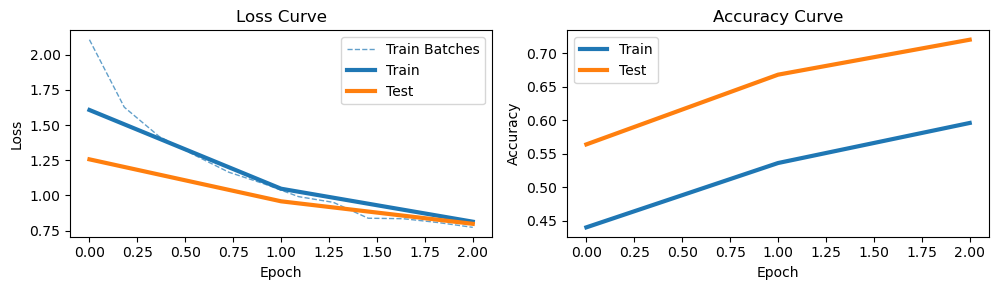

In [138]:
trainer.train(epochs=3, use_gpu=USE_GPU)
trainer.plot()

Epoch 4 :   0%|          | 0/391 [00:00<?, ?it/s]

[4,    97] loss: 0.689
[4,   194] loss: 0.658
[4,   291] loss: 0.660
[4,   388] loss: 0.651
Train Loss : 0.6642056713476205
Train Accuracy : 76.60 %
Val Loss : 0.6964406865307048
Accuracy of the network on the 10000 test images: 75.69 %


Epoch 5 :   0%|          | 0/391 [00:00<?, ?it/s]

[5,    97] loss: 0.537
[5,   194] loss: 0.549
[5,   291] loss: 0.570
[5,   388] loss: 0.552
Train Loss : 0.5514796748947914
Train Accuracy : 78.69 %
Val Loss : 0.6451126985912081
Accuracy of the network on the 10000 test images: 77.76 %


Epoch 6 :   0%|          | 0/391 [00:00<?, ?it/s]

[6,    97] loss: 0.453
[6,   194] loss: 0.465
[6,   291] loss: 0.473
[6,   388] loss: 0.457
Train Loss : 0.46193175006400594
Train Accuracy : 80.44 %
Val Loss : 0.6187196875674815
Accuracy of the network on the 10000 test images: 79.37 %
Finished Training


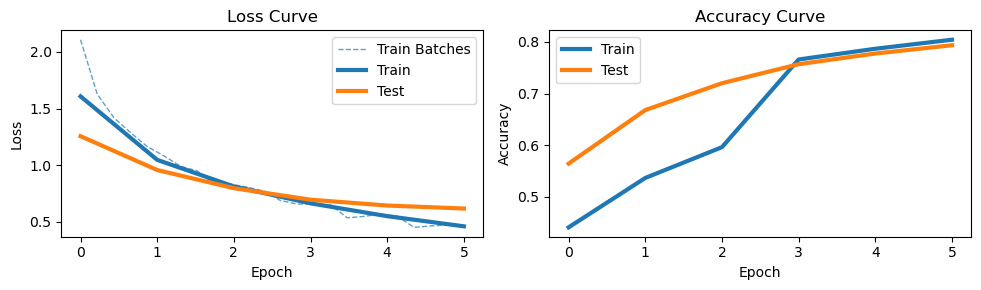

In [139]:
trainer.train(epochs=3, use_gpu=USE_GPU)
trainer.plot()

Epoch 7 :   0%|          | 0/391 [00:00<?, ?it/s]

[7,    97] loss: 0.356
[7,   194] loss: 0.390
[7,   291] loss: 0.385
[7,   388] loss: 0.404
Train Loss : 0.3841052817185516
Train Accuracy : 86.59 %
Val Loss : 0.5841533473775357
Accuracy of the network on the 10000 test images: 80.53 %


Epoch 8 :   0%|          | 0/391 [00:00<?, ?it/s]

[8,    97] loss: 0.285
[8,   194] loss: 0.314
[8,   291] loss: 0.335
[8,   388] loss: 0.343
Train Loss : 0.3195323755445383
Train Accuracy : 87.75 %
Val Loss : 0.6225312514395653
Accuracy of the network on the 10000 test images: 79.60 %


Epoch 9 :   0%|          | 0/391 [00:00<?, ?it/s]

[9,    97] loss: 0.237
[9,   194] loss: 0.257
[9,   291] loss: 0.266
[9,   388] loss: 0.283
Train Loss : 0.2607828979678166
Train Accuracy : 88.85 %
Val Loss : 0.5890046705173541
Accuracy of the network on the 10000 test images: 81.11 %


Epoch 10 :   0%|          | 0/391 [00:00<?, ?it/s]

[10,    97] loss: 0.191
[10,   194] loss: 0.186
[10,   291] loss: 0.221
[10,   388] loss: 0.238
Train Loss : 0.20926214967999618
Train Accuracy : 89.84 %
Val Loss : 0.5784897755218458
Accuracy of the network on the 10000 test images: 81.78 %
Finished Training


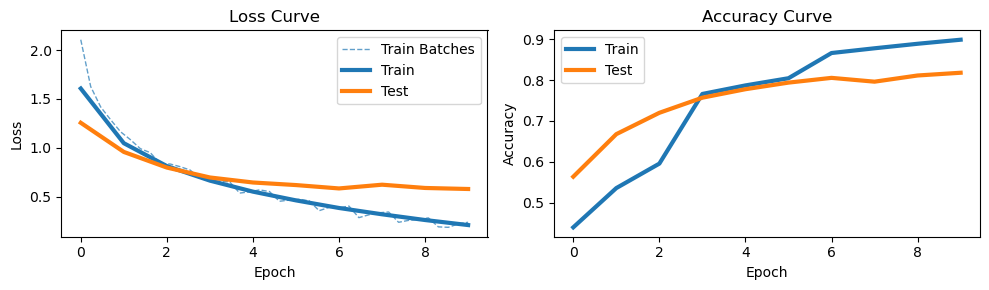

In [140]:
trainer.train(epochs=4, use_gpu=USE_GPU)
trainer.plot()

Epoch 11 :   0%|          | 0/391 [00:00<?, ?it/s]

[11,    97] loss: 0.146
[11,   194] loss: 0.154
[11,   291] loss: 0.175
[11,   388] loss: 0.191
Train Loss : 0.1667729679237851
Train Accuracy : 94.30 %
Val Loss : 0.5740733222116398
Accuracy of the network on the 10000 test images: 82.68 %


Epoch 12 :   0%|          | 0/391 [00:00<?, ?it/s]

[12,    97] loss: 0.118
[12,   194] loss: 0.120
[12,   291] loss: 0.149
[12,   388] loss: 0.161
Train Loss : 0.1372793954142067
Train Accuracy : 94.82 %
Val Loss : 0.624509168199346
Accuracy of the network on the 10000 test images: 81.71 %


Epoch 13 :   0%|          | 0/391 [00:00<?, ?it/s]

[13,    97] loss: 0.099
[13,   194] loss: 0.096
[13,   291] loss: 0.121
[13,   388] loss: 0.132
Train Loss : 0.11295715203065701
Train Accuracy : 95.26 %
Val Loss : 0.6369987797888019
Accuracy of the network on the 10000 test images: 81.92 %


Epoch 14 :   0%|          | 0/391 [00:00<?, ?it/s]

[14,    97] loss: 0.087
[14,   194] loss: 0.083
[14,   291] loss: 0.108
[14,   388] loss: 0.129
Train Loss : 0.10178359417373414
Train Accuracy : 95.60 %
Val Loss : 0.6085930474196808
Accuracy of the network on the 10000 test images: 82.61 %


Epoch 15 :   0%|          | 0/391 [00:00<?, ?it/s]

[15,    97] loss: 0.080
[15,   194] loss: 0.086
[15,   291] loss: 0.106
[15,   388] loss: 0.125
Train Loss : 0.09957701124994041
Train Accuracy : 95.80 %
Val Loss : 0.6109078583083575
Accuracy of the network on the 10000 test images: 83.12 %


Epoch 16 :   0%|          | 0/391 [00:00<?, ?it/s]

[16,    97] loss: 0.076
[16,   194] loss: 0.068
[16,   291] loss: 0.075
[16,   388] loss: 0.083
Train Loss : 0.07529195830645159
Train Accuracy : 96.08 %
Val Loss : 0.6461368018313299
Accuracy of the network on the 10000 test images: 82.58 %


Epoch 17 :   0%|          | 0/391 [00:00<?, ?it/s]

[17,    97] loss: 0.069
[17,   194] loss: 0.068
[17,   291] loss: 0.077
[17,   388] loss: 0.103
Train Loss : 0.07939915380457326
Train Accuracy : 96.25 %
Val Loss : 0.6593764182887499
Accuracy of the network on the 10000 test images: 82.60 %


Epoch 18 :   0%|          | 0/391 [00:00<?, ?it/s]

[18,    97] loss: 0.066
[18,   194] loss: 0.072
[18,   291] loss: 0.076
[18,   388] loss: 0.096
Train Loss : 0.07757316047654432
Train Accuracy : 96.39 %
Val Loss : 0.6469579516332361
Accuracy of the network on the 10000 test images: 83.13 %


Epoch 19 :   0%|          | 0/391 [00:00<?, ?it/s]

[19,    97] loss: 0.058
[19,   194] loss: 0.055
[19,   291] loss: 0.069
[19,   388] loss: 0.075
Train Loss : 0.06431086446203844
Train Accuracy : 96.56 %
Val Loss : 0.657444921098178
Accuracy of the network on the 10000 test images: 82.83 %


Epoch 20 :   0%|          | 0/391 [00:00<?, ?it/s]

[20,    97] loss: 0.060
[20,   194] loss: 0.062
[20,   291] loss: 0.064
[20,   388] loss: 0.087
Train Loss : 0.06835056239943904
Train Accuracy : 96.67 %
Val Loss : 0.7203576436525658
Accuracy of the network on the 10000 test images: 81.46 %
Finished Training


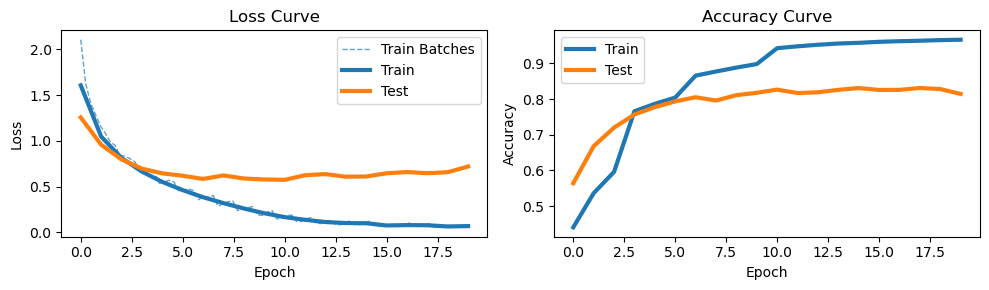

In [141]:
trainer.train(epochs=10, use_gpu=USE_GPU)
trainer.plot()

## Experiment

In [ ]:
class Model2(nn.Module):

  def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model2, self).__init__()
	
    self.debug=debug
    
    self.convs = nn.ModuleList(
        nn.Sequential(
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size),
            #nn.BatchNorm2d(num_features=channels[i+1]),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
        )
        for i in range(n)
    )
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)
    print(f"{self.img_sizes=}")
    
    #self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Sequential(
        nn.Linear(in_features=channels[-1], out_features=len(CLASSES), bias=False),
    )

  def set_debug(self, debug=True):
    self.debug = debug

  def forward(self, x):

    #x = self.conv1(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv2(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv3(x)
    #if self.debug: print(f"M: {x.shape=}")
    
    for conv in self.convs:
        x = conv(x)
        if self.debug: print(f"M conv: {x.shape=}")
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out